In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import time

# Introduction
This file outlines the steps used in training a Pytorch model on EMNIST letter dataset. Test results are stored in 
Pytoch_Classification.ipynb

# Load Dataset

### Define class labels A~Z, the first member here is meaningless

In [2]:
classes = []
classes.append(chr(48))
for i in range(65, 91):
    classes.append(chr(i))
class_size = len(classes)

# 26 letters 
display(np.transpose(classes))
print("class size = ", class_size)

array(['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U1')

class size =  27


In [3]:
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
df = pd.DataFrame(classes, columns=['classes']) 
display(df.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
classes,0,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z


### Construct custom transform

### Define transforms to dataset:   
    1. Convert to tensor model
    2. Normalize data   

In [5]:
transform = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5), (0.5))])

### Load data
When running the following command for the first time, pytorch will prompt you to download the EMNIST dataset.  
Other avaliable datasets are byclass, bymerge, balanced, letters, digits, mnist. Use different dataset by setting `split`.

In [6]:
batch_size = class_size #load one batch per group(A~Z)

# training set
trainset = datasets.EMNIST('data', download=True, \
                                        train=True, transform=transform, split='letters')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.EMNIST('data', download=True, \
                                      train=False, transform=transform, split='letters')

# separate testset into 50% for testing and 50% for validation
testset, validset = random_split(testset, [int(len(testset)/2), int(len(testset)/2)])
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

### Display and check data

The size of each image in data is 28x28.   
Also confirm that 26 images are grabbed from one batch. 

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

torch.Size([27, 1, 28, 28])


Below provides two ways of displaying one batch of dataset. 
1. `imshow` displays one batch without label, so remember to print out labels after calling this function. 
2. `display_batch` displays images with corresponding labels as title, but it processes images slower than `imshow`

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    """ Helper function for displaying one batch of images without labels
    Notice that due to the flipping and rotating when processing EMNIST images, the order 
    of grid is from up to down then from left to right.
    
        Args:
            img: one batch of images
    """
    img = make_grid(images)
    img = img / 2 + 0.5 
    npimg = img.numpy()
    
    # EMNIST dataset is mirroed and rotated
    # convert the images back to regular view
    npimg = np.fliplr(npimg)
    npimg = np.rot90(npimg, axes=(-1,-2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

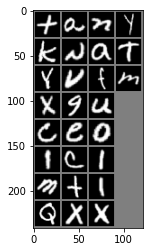

Ground Truth:      T     K     Y     X     C     I     M     Q     A     N     V     Q     E     C     T     X     N     A     F     U     O     I     I     X     Y     T     M


In [9]:
imshow(images)
print("Ground Truth: ", ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
def display_batch(img, labels, n_row=5, n_col=6):
    """ Helper function for displaying one batch of images.
    The default batch size is 26.
    
        Args:
            img: one batch of images
            labels: ground truth or predicted label of images 
            n_row: number of rows of subplots
            n_col: number of columns of subplots
    """
    fig, ax = plt.subplots(n_row,n_col)
    fig.tight_layout(pad=0.1)
    row = 0
    for i, img in enumerate(images):
        if i%n_col == 0 and i > 0:
            row += 1
            
        # EMNIST dataset is mirroed and rotated
        # convert the images back to regular view
        npimg = img.numpy()
        npimg = np.fliplr(npimg)
        npimg = np.rot90(npimg, axes=(-1,-2))
        npimg = np.transpose(npimg, (1, 2, 0))
        
        # configure into subplots
        sub_plot = ax[row, i%n_col]
        sub_plot.imshow(npimg)
        sub_plot.title.set_text(classes[labels[i]])
        # disable xy axis to make room for labels
        sub_plot.get_xaxis().set_visible(False)
        sub_plot.get_yaxis().set_visible(False)
    for i in range(n_row*n_col-len(labels), n_row*n_col):
        # remove unused blocks
        sub_plot = ax[row, i%n_col]
        sub_plot.set_axis_off()
        
    plt.show()

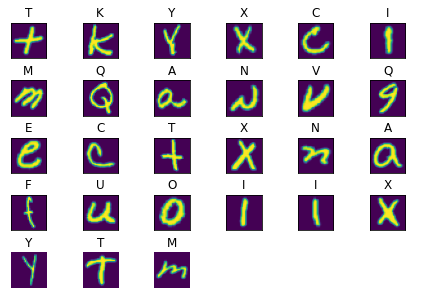

In [11]:
display_batch(images, labels)

## Define Neural Network

In [12]:
class Net(nn.Module):
    """ Neural network for training and classifiying EMNIST dataset.

        Network architecture:
        - max pooling
        - 2D convolution layer of 64 channels and kernal size 5
        - 2D convolution layer of 128 channels and kernal size 5
        - Input layer
        - First hidden layer: fully connected layer of size 128 nodes
        - Second hidden layer: fully connected layer of size 64 nodes
        - Output layer: a linear layer with one node per class 

        Activation function: ReLU for all layers
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, class_size)

    def forward(self, x):
        self.pool = nn.MaxPool2d(2, 2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define Loss Function and Optimizer
Use default `mean` for cross-entropy.   
Learning rate is 0.001.   
Momentum is 0.9.   

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train Network

### Construct helper functions

In [14]:
def train(model, data_loader, device=torch.device('cpu')):
    """ Helper function for training one epoch of neural network.
        
        Args:
            model: the neural network to be trained
            data_loader: for loading the netowrk input and targets from the training dataset
            device: device used when training, default is CPU
            
        Returns:
            model: the trained model
            train_loss: average loss value on the entire training dataset
            train_accuracy: average accuracy on the entire training dataset
    """
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / total
    train_accuracy = correct * 100 / total

    return model, train_loss, train_accuracy

In [15]:
def test(model, data_loader, device=torch.device('cpu')):
    """ Helper function for evaluating a trained neural network on a testing set.
    
        Args:
            model: trained neural network
            data_loader: for loading the netowrk input and targets from the testing or validation dataset
            device: device used when training, default is CPU

        Returns:
            test_loss: average loss value on the entire testing dataset
            test_accuracy: percentage of correctly classified samples in the testing or validation dataset
    """
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    test_loss = running_loss / total
    test_accuracy = correct * 100 / total

    return test_loss, test_accuracy

In [16]:
def train_model(model, train_loader=None, valid_loader=None, n_epochs=1, stop_thr=1e-4):
    """ Helper function for training a model.

        Args:
            model: the neural network to be trained
            train_loader: for loading the netowrk input and targets from the training dataset
            train_loader: for loading the netowrk input and targets from the validation dataset
            n_epochs: maximum number of epoch for training the model
            stop_thre: if the validation loss from one epoch to the next is less than this
                        value, stop training

        Returns:
            model: the trained model
            loss: a list of losses after each epoch of training
            acc:  a list of accuracies after each epoch of training 
    """
    loss = dict({'train': [], 'valid': []})
    acc = dict({'train': [], 'valid': []})
    test_loss_pre = 100000
    begin = time.time()
    for epoch in range(n_epochs):
        # train
        model, train_loss, train_accuracy = train(model, train_loader)
        loss['train'].append(train_loss)
        acc['train'].append(train_accuracy)
        
        # validate
        test_loss, test_accuracy = test(model, valid_loader)
        loss['valid'].append(test_loss)
        acc['valid'].append(test_accuracy)

        if test_loss_pre - test_loss < stop_thr: break
        test_loss_pre = test_loss
        
        print("epoch ", epoch, " --- loss = ", train_loss, " acc = ", train_accuracy, \
              "time = ", time.time()-begin)

    return model, loss, acc

### Start Traning

In [17]:
net, loss, acc = train_model(net, train_loader=trainloader, valid_loader=validloader, n_epochs=10)

/home/laiy/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch  0  --- loss =  0.03666364541017594  acc =  70.45432692307692 time =  287.632164478302
epoch  1  --- loss =  0.011543384781032682  acc =  89.90464743589743 time =  545.9902911186218
epoch  2  --- loss =  0.009081629322549233  acc =  91.8701923076923 time =  823.1550698280334
epoch  3  --- loss =  0.007889797226749718  acc =  92.82291666666667 time =  1106.3504991531372
epoch  4  --- loss =  0.007077320216425832  acc =  93.55528846153847 time =  1359.9804983139038
epoch  5  --- loss =  0.006493620869650607  acc =  93.98717948717949 time =  1604.0112090110779


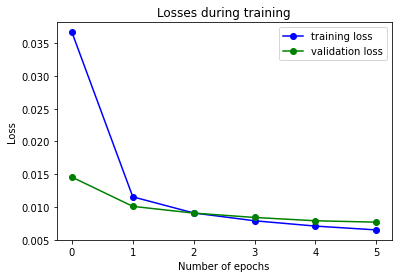

In [18]:
n = range(len(loss['train']))
plt.plot(n, loss['train'], 'bo-', label="training loss")
plt.plot(n, loss['valid'], 'go-', label="validation loss")
plt.title("Losses during training")
plt.xlabel('Number of epochs')
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("training_loss.jpg")
plt.show()

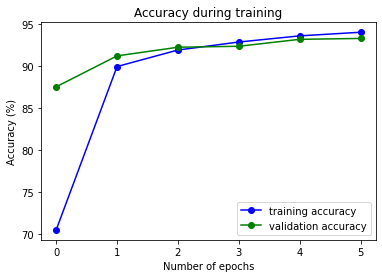

In [19]:
plt.plot(n, acc['train'], 'bo-', label="training accuracy")
plt.plot(n, acc['valid'], 'go-', label="validation accuracy")
plt.title("Accuracy during training")
plt.xlabel('Number of epochs')
plt.ylabel("Accuracy (%)")
plt.legend(loc="lower right")
plt.savefig("training_acc.jpg")
plt.show()

# Save Network

In [20]:
PATH = './model_letters.pth'
torch.save(net.state_dict(), PATH)

In [21]:
# check if model is successfully saved
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Test Network

### Predict on one batch

Gound truth


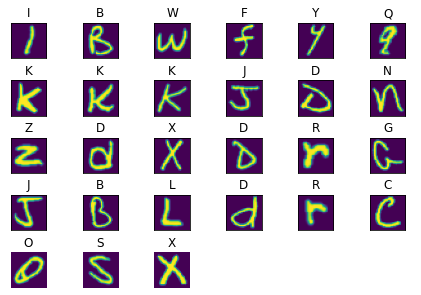

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

print("Gound truth")
display_batch(images, labels)

Prediction


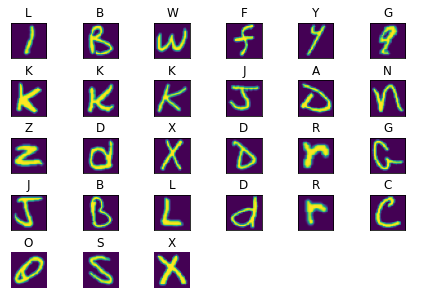

In [23]:
outputs = net(images.float())
_, predicted = torch.max(outputs, 1)

print("Prediction")
display_batch(images, predicted)

### Test of testset

In [24]:
test_loss, test_accuracy = test(net, testloader)
print("Test loss = ", test_loss)
print("Overall test accuracy = ", test_accuracy)

Test loss =  0.007702564745962333
Overall test accuracy =  93.3173076923077


### Test accuracy on each label

In [25]:
def test_each_label(model, data_loader, device=torch.device('cpu')):
    """ Helper function for evaluating a trained neural network on a testing set.
    
        Args:
            model: trained neural network
            data_loader: for loading the netowrk input and targets from the testing dataset
            device: device used when training, default is CPU

        Returns:
            test_loss: average loss value on the entire testing dataset
            test_accuracy: percentage of correctly classified samples in the testing dataset
    """
    class_correct = np.zeros(class_size)
    class_total = np.zeros(class_size)
    class_acc = np.zeros(class_size)
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images.float())
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size()[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(class_size):
        if class_total[i] > 0:
            class_acc[i] = 100 * class_correct[i]/class_total[i]
    
    return class_acc

In [26]:
class_acc = test_each_label(net, testloader)

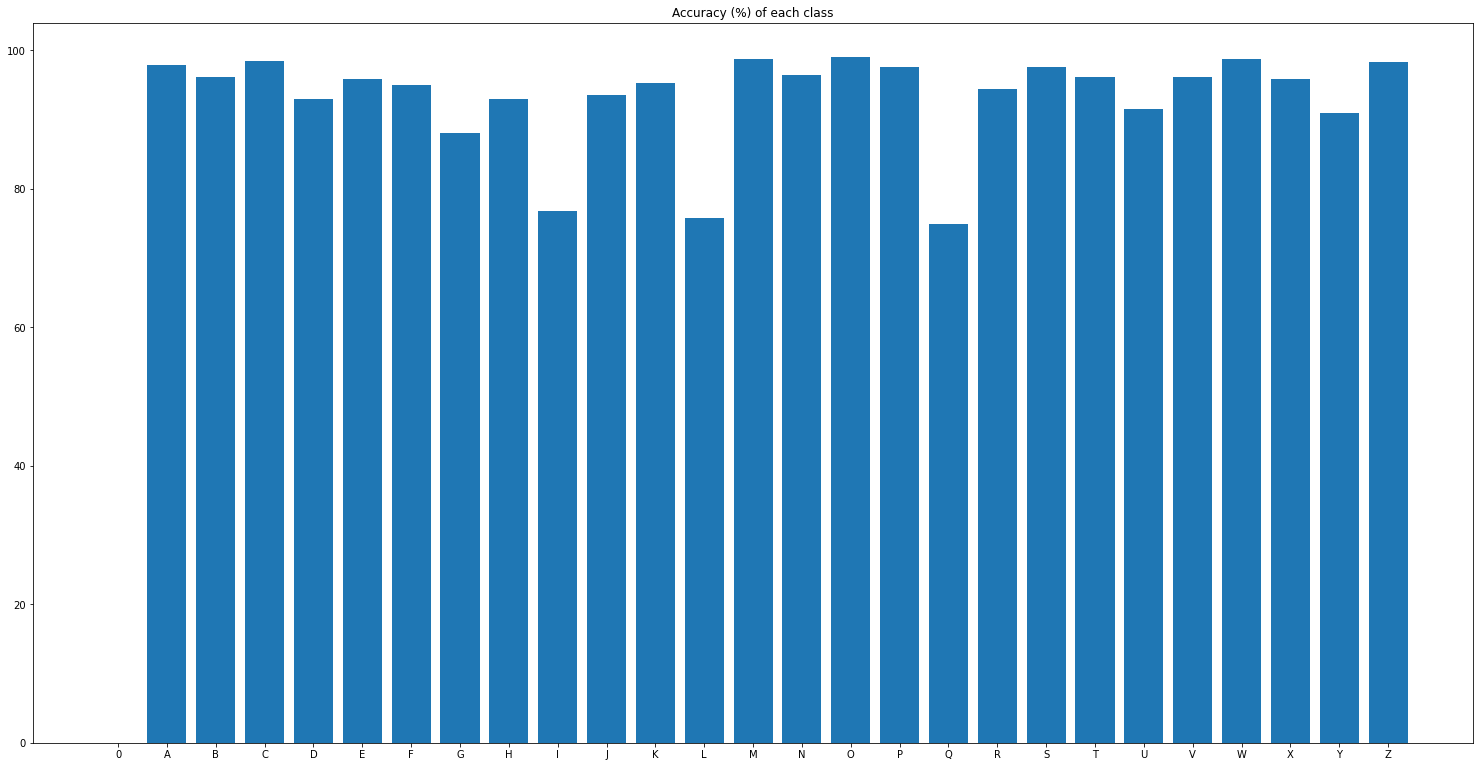

In [27]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,class_acc)
ax.set_title("Accuracy (%) of each class")
fig.savefig("test_acc.jpg", bbox_inches='tight')
plt.show()